In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# Loading the Dataset

In [3]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [4]:
np.unique(y)

array([0, 1])

In [5]:
X.groupby(y).size()

target
0    212
1    357
dtype: int64

# Model Probability Discretization

When we want to build a model to rank, we would like to know if the mean of our target variable increases with the model predicted probability. In order to check that, it is common to discretise the model probabilities that is provided by `model.predict_proba(X)[:, 1]`. If the mean target increases monotonically with each bin boundaries, than we can rest assure that our model is doing some sort of ranking.

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.60, random_state=50)

In [114]:
from sklearn.preprocessing import MinMaxScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

features = X.columns.tolist()

lr_model = Pipeline(steps=[
    ('scaler', SklearnTransformerWrapper(transformer=MinMaxScaler(), variables=features)),
    ('algorithm', LogisticRegression())
])

In [115]:
lr_model.fit(X_train, y_train)

y_proba_train = lr_model.predict_proba(X_train)[:,1]
y_proba_test = lr_model.predict_proba(X_test)[:,1]

In [116]:
from sklearn.metrics import roc_auc_score

print(f"Train ROCAUC: {roc_auc_score(y_train, y_proba_train):.4f}")
print(f"Test ROCAUC: {roc_auc_score(y_test, y_proba_test):.4f}")

Train ROCAUC: 0.9972
Test ROCAUC: 0.9892


Our model is performing very good! But let's check if it is in fact assigning the examples with the greatest chance to acquire breast cancer with higher probabilities.

To do that, let's use the `EqualFrequencyDiscretiser`.

First, let's build a dataframe with the predicted probabilities and the target.

In [117]:
predictions_df = pd.DataFrame({'model_prob': y_proba_test,'target': y_test})
predictions_df.head()

,model_prob,target
356,0.782233,1
556,0.993711,1
283,0.136180,0
495,0.792087,1
364,0.951556,1


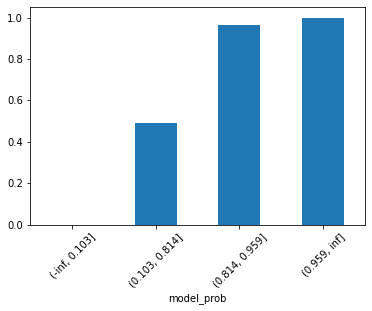

In [119]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

disc = EqualFrequencyDiscretiser(q=4, variables=['model_prob'], return_boundaries=True)
predictions_df_t = disc.fit_transform(predictions_df)
predictions_df_t.groupby('model_prob')['target'].mean().plot(kind='bar', rot=45);

Indeed our model is ranking! But the last two groups/bins with greater probabilities are really close to each other. So, maybe after all we just have 3 groups instead of 4. Wouldn't it be nice if we could use a method that finds the optimum number of groups/bins for us? For this, `feature-engine` gotcha you! Let's use the `DecisionTreeDiscretiser`. As said by Soledad Gali [here](https://trainindata.medium.com/variable-discretization-in-machine-learning-7b09009915c2), this discretisation technique consists of using a decision tree to identify the optimal partitions for a continuous variable, that is what our model probability is.

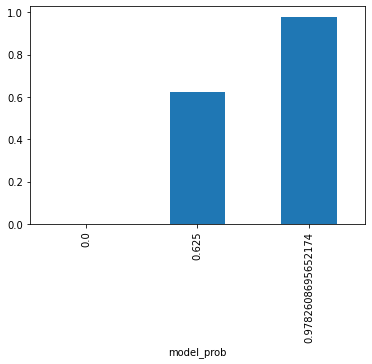

In [120]:
from feature_engine.discretisation import DecisionTreeDiscretiser

disc = DecisionTreeDiscretiser(cv=3, scoring='roc_auc', variables=['model_prob'], regression=False)

predictions_df_t = disc.fit_transform(predictions_df, y_test)

predictions_df_t.groupby('model_prob')['target'].mean().plot(kind='bar');

Very nice! Our `DecisionTreeDiscretiser` have found three optimum bins/groups/clusters to split the model probability. The first group only contains examples that our model says won't develop breast cancer. The second one has a 0.625 probability chance of develop a breast cancer and the third cluster has the greatest chance of develop breast cancer, 0.978.

Let' check the size of each cluster:

In [121]:
predictions_df_t['model_prob'].value_counts().sort_index()

0.000000     82
0.625000      8
0.978261    138
Name: model_prob, dtype: int64

It's a common practice to give letters to each cluster in a way that the letter 'A' for example will be used to denote the cluster with less probability:

In [122]:
import string

tree_predictions = np.sort(predictions_df_t['model_prob'].unique())

ratings_map = {tree_prediction: rating for rating, tree_prediction in zip(string.ascii_uppercase, tree_predictions)}
ratings_map

{0.0: 'A', 0.625: 'B', 0.9782608695652174: 'C'}

In [123]:
predictions_df_t['cluster'] = predictions_df_t['model_prob'].map(ratings_map)
predictions_df_t.head()

,model_prob,target,cluster
356,0.978261,1,C
556,0.978261,1,C
283,0.000000,0,A
495,0.978261,1,C
364,0.978261,1,C


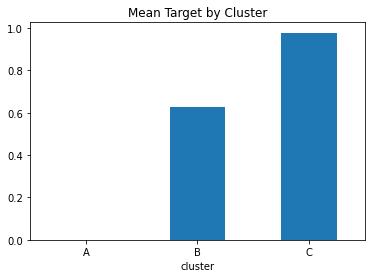

In [124]:
predictions_df_t.groupby('cluster')['target'].mean().plot(kind='bar', rot=0, title="Mean Target by Cluster");

The same figure as the one above, but now with letters to denote each cluster.

To finish, let's see what are the boundaries of each cluster. With that information, once we apply the model to obtain the probability of develop breast cancer for a new sample, we can classify it into one of the three cluster we created with the `DecisionTreeDiscretiser`.

In [125]:
predictions_df_t['model_probability'] = predictions_df['model_prob']
predictions_df_t.head()

,model_prob,target,cluster,model_probability
356,0.978261,1,C,0.782233
556,0.978261,1,C,0.993711
283,0.000000,0,A,0.136180
495,0.978261,1,C,0.792087
364,0.978261,1,C,0.951556


In [126]:
predictions_df_t.groupby('cluster').agg(lower_boundary = ('model_probability', 'min'), upper_boundary=('model_probability', 'max')).round(3)

,lower_boundary,upper_boundary
cluster,,
A,0.000,0.467
B,0.473,0.632
C,0.650,0.998


So, if a new sample gets a probability of 0.72 it will be assigned to cluster C.

# References

To learn more about variable discretization tecniques, please go to https://trainindata.medium.com/variable-discretization-in-machine-learning-7b09009915c2.